In [1]:
import arviz as az
import numpy as np
import pymc as pm

from matplotlib import pylab as plt
from scipy import stats

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


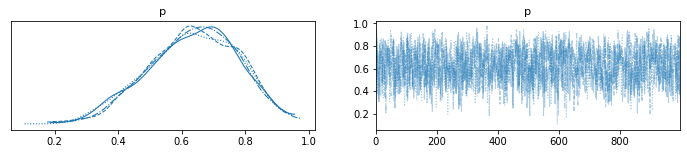

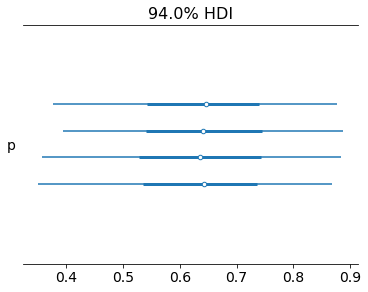

In [3]:
with pm.Model() as our_first_model:
    p = pm.Uniform("p")  # set the prior
    y = pm.Bernoulli("y", p=p, observed=data)  # set the posterior
    trace = pm.sample(1000, chains=4)  # get 1000 random_samples
    az.plot_trace(trace)
    az.plot_forest(trace, var_names=["p"])

In [23]:
trace['posterior'].p

<xarray.DataArray 'p' (chain: 4, draw: 1000)>
array([[0.50234874, 0.87203955, 0.94181646, ..., 0.86034958, 0.88685242,
        0.82930404],
       [0.6863981 , 0.7383462 , 0.50344107, ..., 0.63725207, 0.71512297,
        0.49147184],
       [0.59524689, 0.62203764, 0.70012527, ..., 0.83112037, 0.49412411,
        0.31192085],
       [0.78757305, 0.85524713, 0.77945488, ..., 0.37396745, 0.58467513,
        0.69096528]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

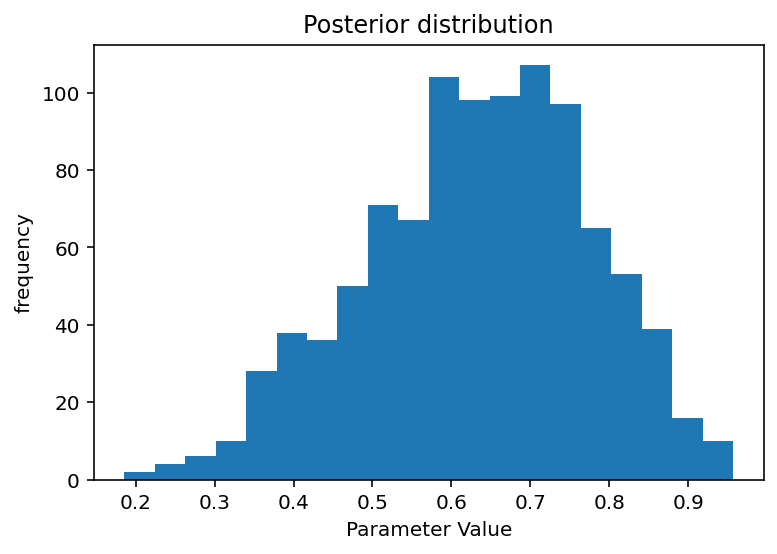

In [25]:
# plot the posterior
plt.hist(trace['posterior'].p[0], bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

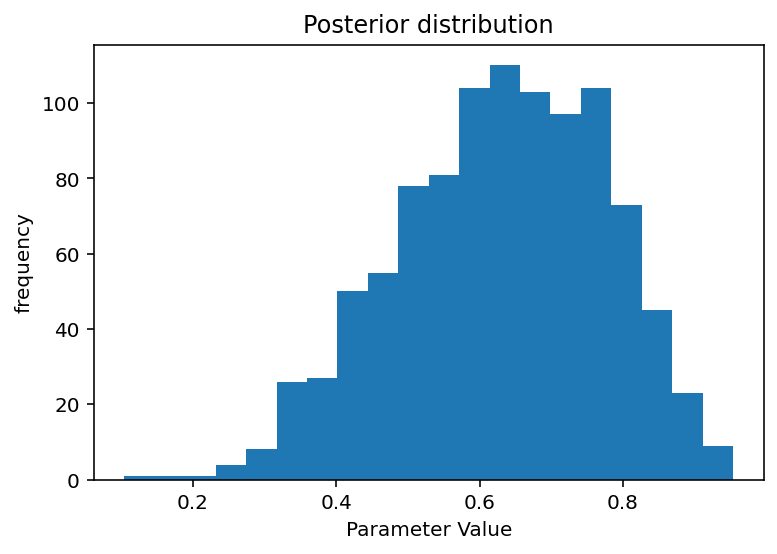

In [26]:
# plot the posterior
plt.hist(trace['posterior'].p[1], bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

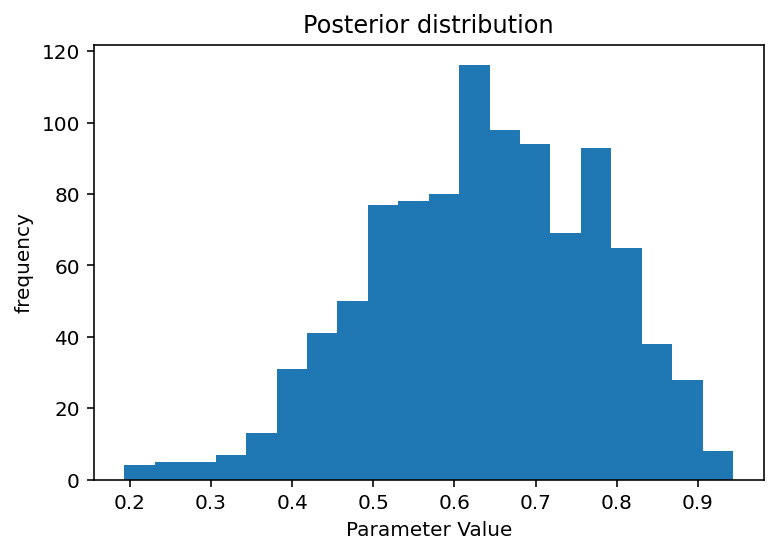

In [27]:
# plot the posterior
plt.hist(trace['posterior'].p[2], bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

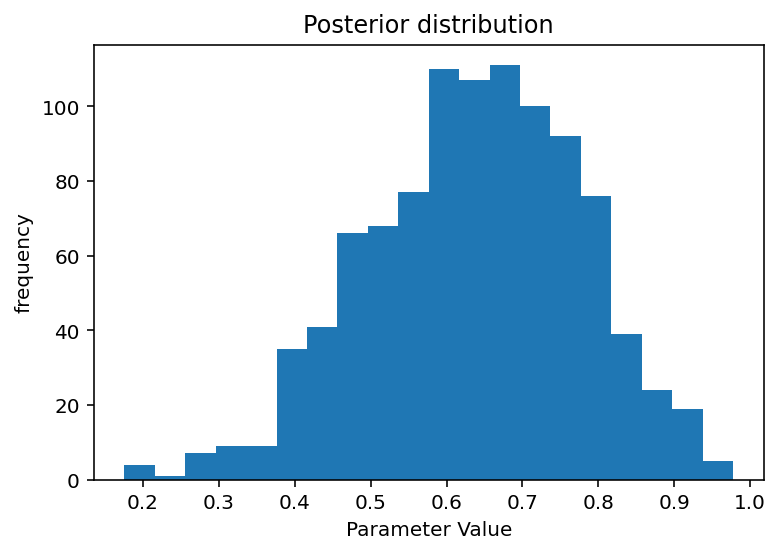

In [28]:
# plot the posterior
plt.hist(trace['posterior'].p[3], bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

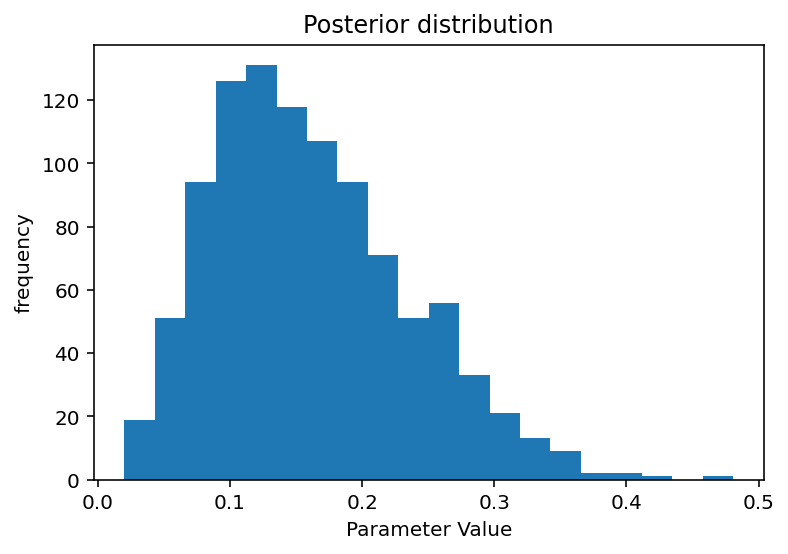

In [29]:
joint = trace['posterior'].p[3] * trace['posterior'].p[2] * trace['posterior'].p[1] * trace['posterior'].p[0]

# plot the posterior
plt.hist(joint, bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

array([[<AxesSubplot:title={'center':'p'}>]], dtype=object)

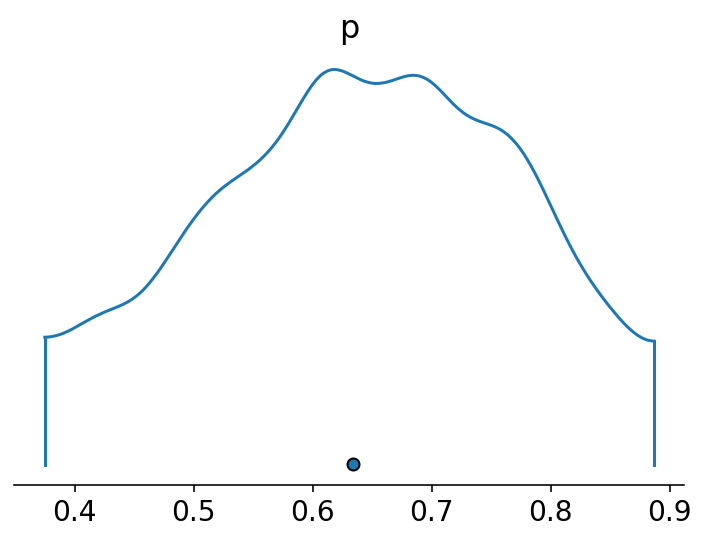

In [34]:
az.plot_density(trace)

Text(0.5, 1.0, 'Posterior plot')

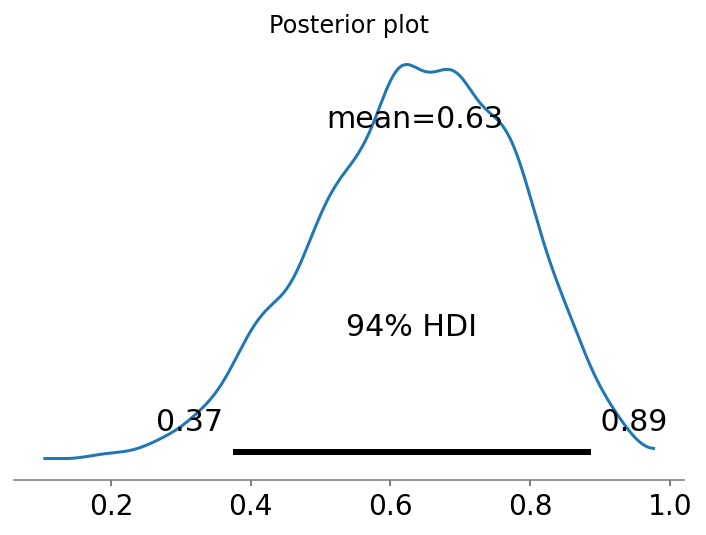

In [36]:
az.plot_posterior(trace)
plt.title('Posterior plot')

In [32]:
pm.__version__

'4.1.5'

### Easy

3E1. How much posterior probability lies below p = 0.2?

In [45]:
samples = trace.posterior.p
np.sum( samples < 0.2) / samples.size

<xarray.DataArray 'p' ()>
array(0.002)

3E2. How much posterior probability lies above p = 0.8?

In [46]:
np.sum( samples > 0.8) / samples.size

<xarray.DataArray 'p' ()>
array(0.12)

3E3. How much posterior probability lies between p = 0.2 and p = 0.8?

In [49]:
(1 - np.sum(samples < 0.2) / samples.size) - np.sum(samples > 0.8) / samples.size # probability of being between 0.2 and 0.8

<xarray.DataArray 'p' ()>
array(0.878)

3E4. 20% of the posterior probability lies below which value of p?

In [51]:
np.quantile(samples,0.2)

0.5134485374649458

3E5. 20% of the posterior probability lies above which value of p?

In [52]:
np.quantile(samples,0.8)

0.7619748214834998

3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [56]:
np.array(az.hdi(samples, hdi_prob=0.66)['p'])

array([0.51506968, 0.78936494])

3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [59]:
np.quantile(samples,(1/6, 5/6))

array([0.49245266, 0.77590651])

### Medium

3M1. Suppose the globe tossing data had turned out tobe 8water in 15 tosses.Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

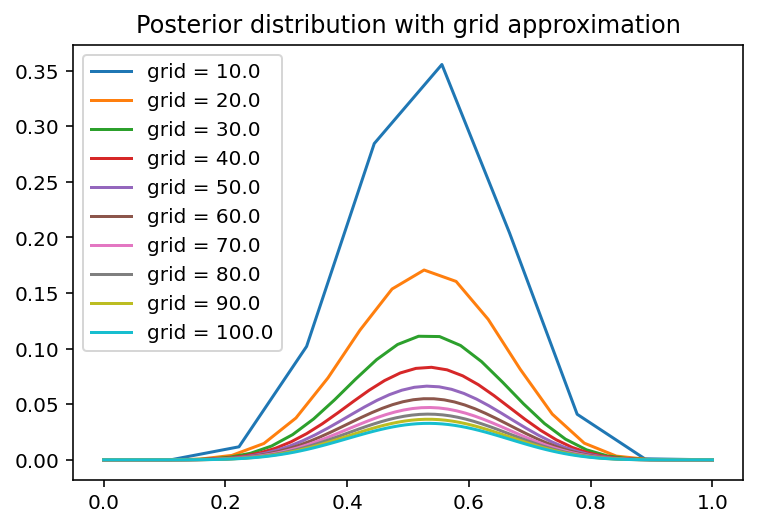

In [63]:
W = 8
T = 15

for grid in np.linspace(10, 100, 10):
    p = np.linspace(0, 1, int(grid)) # grid of probabilities

    Prior = 1 # uniform prior

    posterior_unstd = stats.binom.pmf(W, T, p) * Prior # likelihood * prior
    posterior = posterior_unstd / np.sum(posterior_unstd) # normalize

    plt.plot(p, posterior, label=f"grid = {grid}")
    plt.legend()
    plt.title("Posterior distribution with grid approximation")

3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.

In [72]:
sample = np.random.choice(p,size = 10000,p=posterior)

In [73]:
sample.shape

(10000,)

In [74]:
az.hdi(sample, hdi_prob=0.90)

array([0.34343434, 0.71717172])

3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p.What is the probability of observing 8 water in 15 tosses?

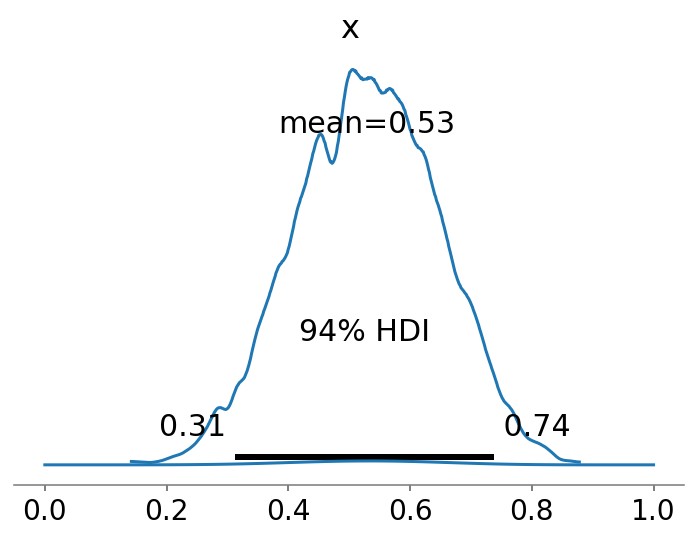

In [76]:
az.plot_posterior(sample)


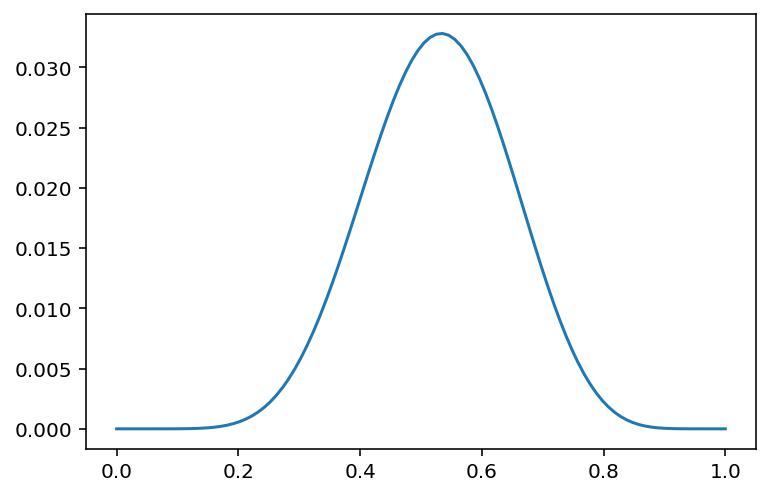

In [77]:
plt.plot(p, posterior, label=f"grid = {grid}")

In [79]:
ppd = np.random.binomial(n=15, p=sample)

In [81]:
ppd.shape

(10000,)

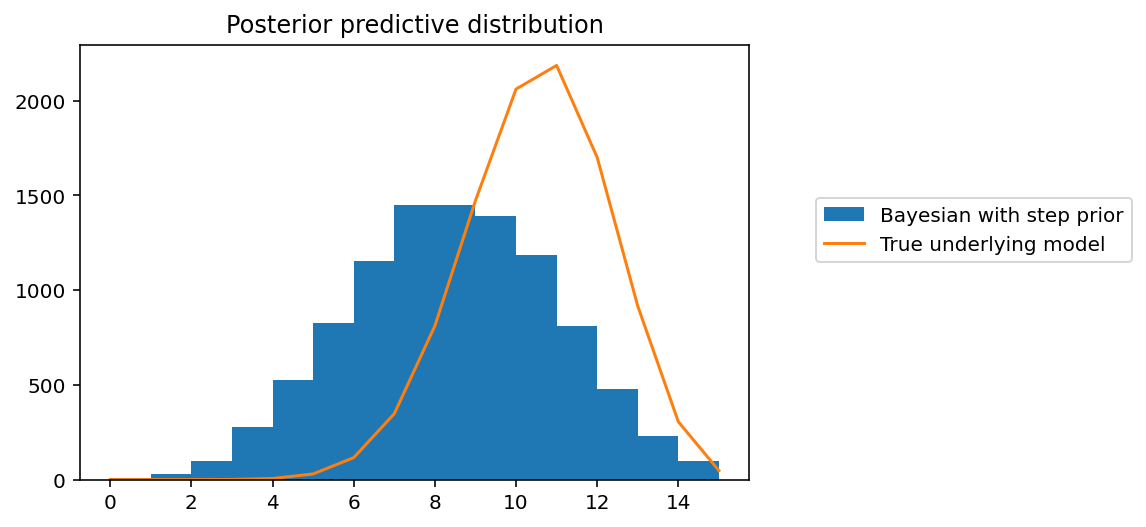

In [84]:
plt.hist(ppd, bins=15, label="Bayesian with step prior")
plt.plot(
    np.linspace(0, 15, 16),
    10000 * stats.binom.pmf(np.linspace(0, 15, 16), n=15, p=0.7),
    label="True underlying model",
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));

3M4. Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [86]:
np.sum(ppd == 6) / ppd.shape

array([0.1153])

3M5. Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value p = 0.7.

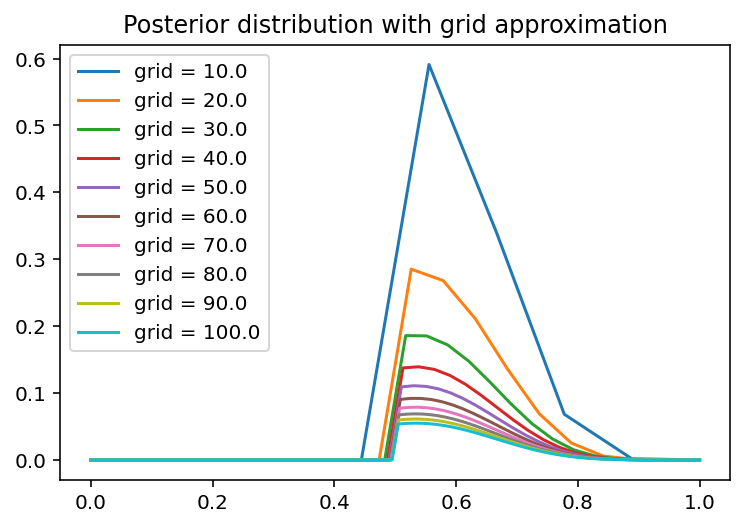

In [90]:
W = 8
T = 15

for grid in np.linspace(10, 100, 10):
    p = np.linspace(0, 1, int(grid)) # grid of probabilities

    Prior = np.heaviside(p - 0.5, 0.5) *0.5 # prior

    posterior_unstd = stats.binom.pmf(W, T, p) * Prior # likelihood * prior
    posterior = posterior_unstd / np.sum(posterior_unstd) # normalize

    plt.plot(p, posterior, label=f"grid = {grid}")
    plt.legend()
    plt.title("Posterior distribution with grid approximation")

In [91]:
sample = np.random.choice(p,size = 10000,p=posterior)
az.hdi(sample, hdi_prob=0.90)

array([0.50505051, 0.70707071])

<AxesSubplot:title={'center':'x'}>

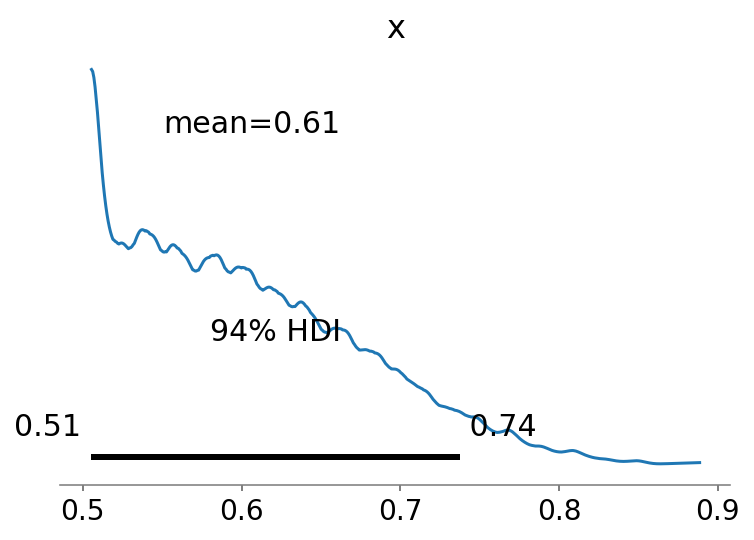

In [92]:
az.plot_posterior(sample)


In [93]:
ppd = np.random.binomial(n=15, p=sample)

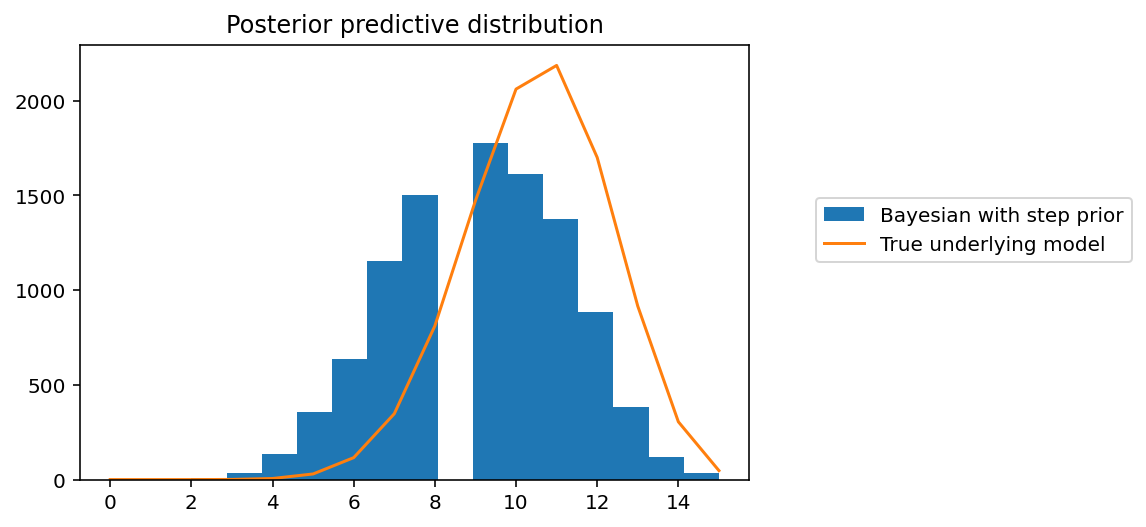

In [94]:
plt.hist(ppd, bins=15, label="Bayesian with step prior")
plt.plot(
    np.linspace(0, 15, 16),
    10000 * stats.binom.pmf(np.linspace(0, 15, 16), n=15, p=0.7),
    label="True underlying model",
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));